In [1]:

import hashlib
import os
import random
import time
from datetime import datetime
from io import BytesIO

import pandas as pd
import praw
import requests
import torch
from PIL import Image
from dask.diagnostics import ProgressBar
from pmaw import PushshiftAPI
from tqdm import tqdm

from shared_code.utility.schemas.pyarrow_schema import schema
from shared_code.utility.spark.set_environ import set_azure_env

set_azure_env()

from shared_code.utility.storage.azure_file_storage import AzureFileStorageAdapter
from shared_code.utility.scripts.blip_caption import BlipCaption

pbar = ProgressBar()
pbar.register()

tqdm.pandas()
tqdm.pandas(desc="global")

from tqdm.dask import TqdmCallback

cb = TqdmCallback(desc="global")
cb.register()

file_system = AzureFileStorageAdapter('data').get_file_storage()

In [2]:
%%time

subs = [
	"SFWRedheads",
	"sfwpetite",
	"SFWNextDoorGirls",
	"trippinthroughtime",
	"fatsquirrelhate",
	"itookapicture",
	"memes",
	"WhitePeopleTwitter",
	"CityPorn",
	"EarthPorn",
	"spaceporn",
	"realasians",
	"KoreanHotties",
	"prettyasiangirls",
	"AsianOfficeLady",
	"mildlypenis",
	"cougars_and_milfs_sfw",
	"AsianInvasion",
	"sexygirls",
	"PrettyGirls",
	"gentlemanboners",
	"hotofficegirls",
	"tightdresses",
	"DLAH"
]


CPU times: total: 0 ns
Wall time: 0 ns


In [3]:
%%time

extant_data = pd.read_parquet("data/processed_raw_data.parquet", engine='pyarrow', filesystem=file_system, schema=schema)
display(extant_data)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,model,exists,curated,accept,tags
0,128z5ns,celebrities,A-Sexy-Name,Rachel Weisz,cars are parked on the side of the road in the...,f09b1c0c5dea50c934081a04c83d4d33,/r/celebrities/comments/128z5ns/rachel_weisz/,https://i.redd.it/nv80afddacra1.jpg,f09b1c0c5dea50c934081a04c83d4d33.jpg,D:\data\images\celebrities\f09b1c0c5dea50c9340...,None,True,False,None,None
1,11yk8db,prettyasiangirls,MisoShiru520,Library,blonde woman with blonde hair and tattoos on h...,9d5b7331b941ecf3fdbc8ad322303825,/r/prettyasiangirls/comments/11yk8db/library/,https://i.redd.it/ht4d2wuusapa1.jpg,9d5b7331b941ecf3fdbc8ad322303825.jpg,D:\data\images\prettyasiangirls\9d5b7331b941ec...,None,True,False,None,None
2,11hfioi,KoreanHotties,Majestic_Painter8660,Underboob bikini,a man with a beard and a beard sitting in fron...,a154a56b1b87cf3a0bc93600c86e4585,/r/KoreanHotties/comments/11hfioi/underboob_bi...,https://i.redd.it/cimr17q84jla1.jpg,a154a56b1b87cf3a0bc93600c86e4585.jpg,D:\ImageDoesNotExist.png,None,False,False,None,None
3,1000mjs,spaceporn,MorningStar_imangi,Northern Lights above Lofoten,a view of a view of a large green and purple a...,2c39ce1290fba541abd0b004b09da6b2,/r/spaceporn/comments/1000mjs/northern_lights_...,https://i.redd.it/7s5aafaqkb9a1.jpg,7s5aafaqkb9a1.jpg,D:\data\images\spaceporn\7s5aafaqkb9a1.jpg,None,True,False,None,None
4,1000qpd,spaceporn,MorningStar_imangi,Viking Lights,a scene of a boat is sitting on the shore of a...,0f72de47c69ff50eca5fa3990215f4ac,/r/spaceporn/comments/1000qpd/viking_lights/,https://i.redd.it/abojw7lqlb9a1.jpg,abojw7lqlb9a1.jpg,D:\data\images\spaceporn\abojw7lqlb9a1.jpg,None,True,False,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41500,131dso7,DLAH,Wallydinger123,Happy B Day,there are three women posing for a picture in ...,ebb4b4a88dc79e2f2f57b10f32bf03c0,/r/DLAH/comments/131dso7/happy_b_day/,https://i.redd.it/36gurz533jwa1.jpg,ebb4b4a88dc79e2f2f57b10f32bf03c0.jpg,D:\data\images\DLAH\ebb4b4a88dc79e2f2f57b10f32...,None,True,False,None,None
41501,131eznp,DLAH,Long_dong111,Perfect,araffe woman in a white dress sitting on a pur...,5c944c6d62b1ae182c5a6a40c64195f4,/r/DLAH/comments/131eznp/perfect/,https://i.redd.it/dnbbx4zucjwa1.jpg,5c944c6d62b1ae182c5a6a40c64195f4.jpg,D:\data\images\DLAH\5c944c6d62b1ae182c5a6a40c6...,None,True,False,None,None
41502,131g3am,DLAH,ThrownAwayMiles,DLAH left or right,two women in short dresses posing for a pictur...,ab1f8fc33c85f4cfce12c810cf22229e,/r/DLAH/comments/131g3am/dlah_left_or_right/,https://i.redd.it/zpp70oor3lwa1.jpg,ab1f8fc33c85f4cfce12c810cf22229e.jpg,D:\data\images\DLAH\ab1f8fc33c85f4cfce12c810cf...,None,True,False,None,None
41503,131jvcx,DLAH,robok212,Good morning 😍,araffe in a pink dress posing on a white wall,01f5058855526ef25888cff88065db4c,/r/DLAH/comments/131jvcx/good_morning/,https://i.redd.it/ozmbfhjv3mwa1.jpg,01f5058855526ef25888cff88065db4c.jpg,D:\data\images\DLAH\01f5058855526ef25888cff880...,None,True,False,None,None


CPU times: total: 344 ms
Wall time: 1.34 s


In [4]:
%%time

reddit: praw.Reddit = praw.Reddit(client_id='5hVavL0PIRyM_1JSvqT6UQ', client_secret='BjD2kS3WNLnJc59RKY-JJUuc_Z9-JA', user_agent='script:%(bot_name)s:v%(bot_version)s (by /u/%(bot_author)s)')
api: PushshiftAPI = PushshiftAPI(praw=reddit, num_workers=12)

CPU times: total: 31.2 ms
Wall time: 139 ms


Version 7.6.1 of praw is outdated. Version 7.7.0 was released Saturday February 25, 2023.


In [5]:
%%time

from dask.callbacks import Callback
from tqdm.autonotebook import tqdm


class TQDMDaskProgressBar(Callback, object):
	"""
    A tqdm progress bar for dask.
    Usage:
        ```
        with TQDMDaskProgressBar():
            da.compute()
        ```
    Author : wassname
    Source : https://gist.github.com/wassname/1837d0365247430e02abda41f0e7f184
    See: http://dask.pydata.org/en/latest/diagnostics-local.html?highlight=progress
    """

	def __init__(self, start=None, start_state=None, pretask=None, posttask=None, finish=None, **kwargs):
		super(TQDMDaskProgressBar, self).__init__(
			start=start,
			start_state=start_state,
			pretask=pretask,
			posttask=posttask,
			finish=finish,
		)
		self.tqdm_args = kwargs
		self.states = ["ready", "waiting", "running", "finished"]

	def _start_state(self, dsk, state):
		self._tqdm = tqdm(total=sum(len(state[k]) for k in self.states), **self.tqdm_args)

	def _posttask(self, key, result, dsk, state, worker_id):
		self._tqdm.update(1)

	def _finish(self, dsk, state, errored):
		self._tqdm.close()

CPU times: total: 0 ns
Wall time: 0 ns


In [6]:
def filter_by_image_post(item) -> bool:
	return not (item['selftext'].__contains__('[removed]') or item['selftext'].__contains__('[deleted]') and not item[
		'url'].endswith('.jpg'))

In [7]:
def fetch_image(x: object) -> object:
	try:
		time.sleep(0.1)
		url = x['original_url']
		subreddit = x['subreddit']
		response = requests.get(url)
		md5 = hashlib.md5(response.content).hexdigest()
		os.makedirs(f"D:\\data\\images\\{subreddit}", exist_ok=True)
		out_path = f"D:\\data\\images\\{subreddit}\\{md5}.jpg"

		if os.path.exists(out_path):
			return out_path

		if md5 in list(extant_data['hash']):
			return out_path

		if md5 != "f17b01901c752c1bb04928131d1661af" or md5 != "d835884373f4d6c8f24742ceabe74946":
			raw_image = Image.open(BytesIO(response.content))
			raw_image.save(out_path)
			raw_image.close()
			return out_path
		else:
			return ""
	except Exception as e:
		print(e)
		return ""

In [8]:
def exists(x: object) -> bool:
	try:
		image_path = os.path.exists(x['path'])
		return image_path
	except Exception as e:
		print(e)
		return False

In [9]:
def split_hash(x: object) -> str:
	try:
		name = x['image_name']
		return name.split('.')[0]
	except Exception as e:
		print(e)
		return ""

In [10]:
def caption_image(x: object, blip_captioning_list: [BlipCaption, BlipCaption]) -> str:
	try:
		path = x['path']
		exists_image = bool(x['exists'])
		resulting_caption = x['caption']

		if not os.path.exists(path):
			return ""

		if not exists_image:
			return ""

		if resulting_caption == None:
			pass
		if resulting_caption is None:
			pass
		else:
			if len(resulting_caption) > 6:
				return resulting_caption
			if resulting_caption != "":
				return resulting_caption
			else:
				pass

		blip_captioning = random.choice(blip_captioning_list)

		resulting_caption = blip_captioning.caption_image(path)

		return resulting_caption

	except Exception as e:
		print(e)
		return ""
	finally:
		pass

In [11]:
def get_image_name(x: object) -> str:
	try:
		path = x['path']
		if path == "":
			return ""
		return os.path.basename(path)
	except Exception as e:
		print(e)
		return ""

In [12]:
from praw.models import ListingGenerator
import pandas as pd

posts = []
for sub in tqdm(subs, total=len(subs), desc="Creating subs"):
	if not os.path.exists(f"{sub}"):
		os.makedirs(f"{sub}")
	existing_data = pd.read_parquet(f"{sub}")
	os.makedirs(f"{sub}", exist_ok=True)

Creating subs:   0%|          | 0/24 [00:00<?, ?it/s]

In [13]:
# 'all', 'year', 'month',
for time_filter in ['week', 'day']:
	for sub in tqdm(subs, desc=f"{time_filter}", total=len(subs)):
		existing_data = pd.read_parquet(f"{sub}")
		try:
			subreddit_stream: ListingGenerator = reddit.subreddit(display_name=sub).top(limit=100, time_filter=time_filter)
			subreddit_stream = list(subreddit_stream)
			for submission in tqdm(subreddit_stream, total=len(subreddit_stream), desc=f"Posts - {sub} - {time_filter}"):
				if submission is None:
					continue
				if not os.path.exists(f"{sub}"):
					os.makedirs(f"{sub}")
				else:
					if submission.id in list(extant_data['id']):
						continue
				try:
					author_name = 'Unknown'
					subreddit_name = sub
					try:
						author_name = submission.author.name
					except Exception as e:
						author_name = 'Unknown'
						pass
					p = {
						'id': submission.id,
						'subreddit': subreddit_name,
						'author': author_name,
						'title': submission.title,
						'caption': '',
						'hash': '',
						'permalink': submission.permalink,
						'original_url': submission.url,
						'image_name': '',
						'path': '',
						'thumbnail_path': '',
						'exists': False,
						'curated': False
					}
					pd.DataFrame([p]).to_parquet(f"{sub}/{submission.id}-{time_filter}.parquet")
				except Exception as e:
					# print(e)
					continue
		except Exception as e:
			print(e)
			continue

all:   0%|          | 0/24 [00:00<?, ?it/s]

Posts - SFWRedheads - all:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - sfwpetite - all:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - SFWNextDoorGirls - all:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - trippinthroughtime - all:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - fatsquirrelhate - all:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - itookapicture - all:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - memes - all:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - WhitePeopleTwitter - all:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - CityPorn - all:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - EarthPorn - all:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - spaceporn - all:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - realasians - all:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - KoreanHotties - all:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - prettyasiangirls - all:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - AsianOfficeLady - all:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - mildlypenis - all:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - cougars_and_milfs_sfw - all:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - AsianInvasion - all:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - sexygirls - all:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - PrettyGirls - all:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - gentlemanboners - all:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - hotofficegirls - all:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - tightdresses - all:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - DLAH - all:   0%|          | 0/100 [00:00<?, ?it/s]

year:   0%|          | 0/24 [00:00<?, ?it/s]

Posts - SFWRedheads - year:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - sfwpetite - year:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - SFWNextDoorGirls - year:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - trippinthroughtime - year:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - fatsquirrelhate - year:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - itookapicture - year:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - memes - year:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - WhitePeopleTwitter - year:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - CityPorn - year:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - EarthPorn - year:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - spaceporn - year:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - realasians - year:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - KoreanHotties - year:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - prettyasiangirls - year:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - AsianOfficeLady - year:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - mildlypenis - year:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - cougars_and_milfs_sfw - year:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - AsianInvasion - year:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - sexygirls - year:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - PrettyGirls - year:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - gentlemanboners - year:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - hotofficegirls - year:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - tightdresses - year:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - DLAH - year:   0%|          | 0/100 [00:00<?, ?it/s]

month:   0%|          | 0/24 [00:00<?, ?it/s]

Posts - SFWRedheads - month:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - sfwpetite - month:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - SFWNextDoorGirls - month:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - trippinthroughtime - month:   0%|          | 0/89 [00:00<?, ?it/s]

Posts - fatsquirrelhate - month:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - itookapicture - month:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - memes - month:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - WhitePeopleTwitter - month:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - CityPorn - month:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - EarthPorn - month:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - spaceporn - month:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - realasians - month:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - KoreanHotties - month:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - prettyasiangirls - month:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - AsianOfficeLady - month:   0%|          | 0/59 [00:00<?, ?it/s]

Posts - mildlypenis - month:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - cougars_and_milfs_sfw - month:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - AsianInvasion - month:   0%|          | 0/81 [00:00<?, ?it/s]

Posts - sexygirls - month:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - PrettyGirls - month:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - gentlemanboners - month:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - hotofficegirls - month:   0%|          | 0/61 [00:00<?, ?it/s]

Posts - tightdresses - month:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - DLAH - month:   0%|          | 0/100 [00:00<?, ?it/s]

week:   0%|          | 0/24 [00:00<?, ?it/s]

Posts - SFWRedheads - week:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - sfwpetite - week:   0%|          | 0/40 [00:00<?, ?it/s]

Posts - SFWNextDoorGirls - week:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - trippinthroughtime - week:   0%|          | 0/18 [00:00<?, ?it/s]

Posts - fatsquirrelhate - week:   0%|          | 0/98 [00:00<?, ?it/s]

Posts - itookapicture - week:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - memes - week:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - WhitePeopleTwitter - week:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - CityPorn - week:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - EarthPorn - week:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - spaceporn - week:   0%|          | 0/97 [00:00<?, ?it/s]

Posts - realasians - week:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - KoreanHotties - week:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - prettyasiangirls - week:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - AsianOfficeLady - week:   0%|          | 0/14 [00:00<?, ?it/s]

Posts - mildlypenis - week:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - cougars_and_milfs_sfw - week:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - AsianInvasion - week:   0%|          | 0/15 [00:00<?, ?it/s]

Posts - sexygirls - week:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - PrettyGirls - week:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - gentlemanboners - week:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - hotofficegirls - week:   0%|          | 0/10 [00:00<?, ?it/s]

Posts - tightdresses - week:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - DLAH - week:   0%|          | 0/100 [00:00<?, ?it/s]

day:   0%|          | 0/24 [00:00<?, ?it/s]

Posts - SFWRedheads - day:   0%|          | 0/44 [00:00<?, ?it/s]

Posts - sfwpetite - day:   0%|          | 0/5 [00:00<?, ?it/s]

Posts - SFWNextDoorGirls - day:   0%|          | 0/92 [00:00<?, ?it/s]

Posts - trippinthroughtime - day:   0%|          | 0/3 [00:00<?, ?it/s]

Posts - fatsquirrelhate - day:   0%|          | 0/17 [00:00<?, ?it/s]

Posts - itookapicture - day:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - memes - day:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - WhitePeopleTwitter - day:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - CityPorn - day:   0%|          | 0/40 [00:00<?, ?it/s]

Posts - EarthPorn - day:   0%|          | 0/30 [00:00<?, ?it/s]

Posts - spaceporn - day:   0%|          | 0/13 [00:00<?, ?it/s]

Posts - realasians - day:   0%|          | 0/39 [00:00<?, ?it/s]

Posts - KoreanHotties - day:   0%|          | 0/14 [00:00<?, ?it/s]

Posts - prettyasiangirls - day:   0%|          | 0/25 [00:00<?, ?it/s]

Posts - AsianOfficeLady - day:   0%|          | 0/2 [00:00<?, ?it/s]

Posts - mildlypenis - day:   0%|          | 0/45 [00:00<?, ?it/s]

Posts - cougars_and_milfs_sfw - day:   0%|          | 0/30 [00:00<?, ?it/s]

Posts - AsianInvasion - day:   0%|          | 0/2 [00:00<?, ?it/s]

Posts - sexygirls - day:   0%|          | 0/12 [00:00<?, ?it/s]

Posts - PrettyGirls - day:   0%|          | 0/12 [00:00<?, ?it/s]

Posts - gentlemanboners - day:   0%|          | 0/37 [00:00<?, ?it/s]

Posts - hotofficegirls - day:   0%|          | 0/3 [00:00<?, ?it/s]

Posts - tightdresses - day:   0%|          | 0/43 [00:00<?, ?it/s]

Posts - DLAH - day:   0%|          | 0/33 [00:00<?, ?it/s]

In [28]:
%%time
dfs = pd.DataFrame({}, columns=schema.names)
data = []
for sub in subs:
	df = pd.read_parquet(f"{sub}")
	initial = pd.DataFrame({}, columns=schema.names)
	initial.id = df.id
	initial.subreddit = df.subreddit
	initial.author = df.author
	initial.title = df.title
	initial.caption = ""
	initial.hash = ""
	initial.permalink = df.permalink
	initial.original_url = df.original_url
	initial.image_name = ""
	initial.path = ""
	initial.thumbnail_path = ""
	initial.exists = False
	initial.curated = False
	initial.model = ""
	initial.accept = False
	initial.tags = None

	records = df.to_dict(orient='records')

	data.extend(records)

initial = pd.DataFrame(data=data, columns=schema.names)
filtered_initial = initial.where(initial['original_url'].str.endswith('.jpg')).dropna(how='all').reset_index().drop('index', axis=1)

display(filtered_initial)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,model,exists,curated,accept,tags
0,100zkn4,SFWRedheads,ChanceUnlikely659,Cute mirror pic for you🤍,,,/r/SFWRedheads/comments/100zkn4/cute_mirror_pi...,https://i.redd.it/hhuwwg4yqk9a1.jpg,,,NaN,False,False,NaN,NaN
1,100zkn4,SFWRedheads,ChanceUnlikely659,Cute mirror pic for you🤍,,,/r/SFWRedheads/comments/100zkn4/cute_mirror_pi...,https://i.redd.it/hhuwwg4yqk9a1.jpg,,,NaN,False,False,NaN,NaN
2,100zkn4,SFWRedheads,ChanceUnlikely659,Cute mirror pic for you🤍,,,/r/SFWRedheads/comments/100zkn4/cute_mirror_pi...,https://i.redd.it/hhuwwg4yqk9a1.jpg,,,NaN,False,False,NaN,NaN
3,101h21m,SFWRedheads,ChanceUnlikely659,Do you like my little black dress? 🖤,,,/r/SFWRedheads/comments/101h21m/do_you_like_my...,https://i.redd.it/wirfsk0s9p9a1.jpg,,,NaN,False,False,NaN,NaN
4,101h21m,SFWRedheads,ChanceUnlikely659,Do you like my little black dress? 🖤,,,/r/SFWRedheads/comments/101h21m/do_you_like_my...,https://i.redd.it/wirfsk0s9p9a1.jpg,,,NaN,False,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12121,zrcokh,DLAH,LetReal1805,Jaw dropper,,,/r/DLAH/comments/zrcokh/jaw_dropper/,https://i.redd.it/i5h6kx2vm87a1.jpg,,,NaN,False,False,NaN,NaN
12122,zufk0e,DLAH,mikano96,Cutie,,,/r/DLAH/comments/zufk0e/cutie/,https://i.redd.it/ry23hojujx7a1.jpg,,,NaN,False,False,NaN,NaN
12123,zvn0a6,DLAH,ThePinkTaco65,showing lots,,,/r/DLAH/comments/zvn0a6/showing_lots/,https://i.redd.it/u9w5hzlgba8a1.jpg,,,NaN,False,False,NaN,NaN
12124,zxkmz0,DLAH,-SirSpankalot-,Red wrapped candy,,,/r/DLAH/comments/zxkmz0/red_wrapped_candy/,https://i.redd.it/m5elilvrtq8a1.jpg,,,NaN,False,False,NaN,NaN


CPU times: total: 59.1 s
Wall time: 11.2 s


,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,model,exists,curated,accept,tags
0,120ekkv,SFWRedheads,Tana_Lee,Have a great weekend boys 😘,,,/r/SFWRedheads/comments/120ekkv/have_a_great_w...,https://i.redd.it/8w177b9l1ppa1.jpg,,,NaN,False,False,NaN,NaN
1,120ekkv,SFWRedheads,Tana_Lee,Have a great weekend boys 😘,,,/r/SFWRedheads/comments/120ekkv/have_a_great_w...,https://i.redd.it/8w177b9l1ppa1.jpg,,,NaN,False,False,NaN,NaN
2,12jm6mv,SFWRedheads,Redhotwife88,Redhead Mom at 35 years old ! [F],,,/r/SFWRedheads/comments/12jm6mv/redhead_mom_at...,https://i.imgur.com/nWeLBAM.jpg,,,NaN,False,False,NaN,NaN
3,12jm6mv,SFWRedheads,Redhotwife88,Redhead Mom at 35 years old ! [F],,,/r/SFWRedheads/comments/12jm6mv/redhead_mom_at...,https://i.imgur.com/nWeLBAM.jpg,,,NaN,False,False,NaN,NaN
4,12jqjkk,SFWRedheads,crystalcolette,"Red hair, blue eyes and so many freckles",,,/r/SFWRedheads/comments/12jqjkk/red_hair_blue_...,https://i.redd.it/jcwet8iloita1.jpg,,,NaN,False,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1856,133y5u6,DLAH,-SirSpankalot-,Open buffet,,,/r/DLAH/comments/133y5u6/open_buffet/,https://i.redd.it/j9pvks78o3xa1.jpg,,,NaN,False,False,NaN,NaN
1857,133ykc1,DLAH,Virtual-Pressure-948,Black Hole Dress,,,/r/DLAH/comments/133ykc1/black_hole_dress/,https://i.redd.it/l3akos88r3xa1.jpg,,,NaN,False,False,NaN,NaN
1858,wrq8jd,DLAH,zUUmee,Emma and Olivia,,,/r/DLAH/comments/wrq8jd/emma_and_olivia/,https://i.imgur.com/vC03BwB.jpg,,,NaN,False,False,NaN,NaN
1859,wwp80d,DLAH,-SirSpankalot-,Italian sports TV is superior,,,/r/DLAH/comments/wwp80d/italian_sports_tv_is_s...,https://i.redd.it/unosrxq63pj91.jpg,,,NaN,False,False,NaN,NaN


CPU times: total: 1.42 s
Wall time: 2.74 s


<Axes: xlabel='subreddit'>

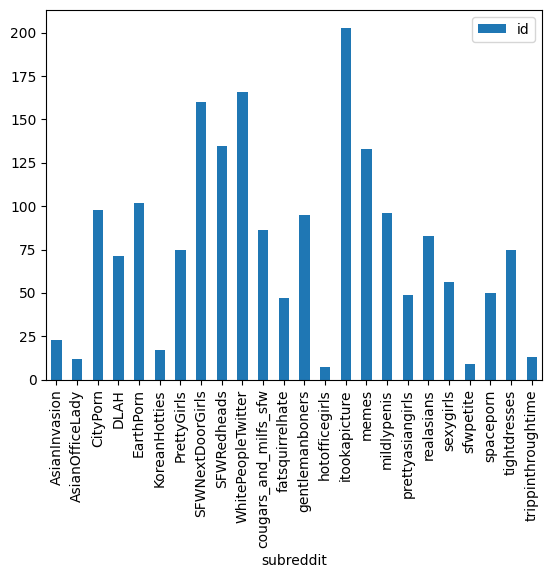

In [29]:
%%time

tqdm.pandas(desc="Filtering Exists For Id List")
with ProgressBar():
	extant = extant_data.where((extant_data['exists'].isin([True]))).dropna(how='all').reset_index().drop('index', axis=1)

extant_id_list = list(extant.id)

tqdm.pandas(desc="Filtering Based on Id")
with ProgressBar():
	new_entries = filtered_initial.where((~filtered_initial['id'].isin(extant_id_list))).dropna(
		how='all').reset_index().drop('index', axis=1)

display(new_entries)

new_images_by_sub = new_entries.groupby('subreddit')

new_images_by_sub.count().plot.bar(y='id')

In [30]:
%%time

new_entries_1 = new_entries.copy()

tqdm.pandas(desc="Fetch-Image")
with ProgressBar():
	new_entries_1['path'] = new_entries_1.progress_apply(lambda x: fetch_image(x), axis=1)

tqdm.pandas(desc="Get-Image-Name")
with ProgressBar():
	new_entries_1['image_name'] = new_entries_1.progress_apply(lambda x: get_image_name(x), axis=1)

tqdm.pandas(desc="Split-Hash")
with ProgressBar():
	new_entries_1['hash'] = new_entries_1.progress_apply(lambda x: split_hash(x), axis=1)

tqdm.pandas(desc="Checking-Exists")
with ProgressBar():
	new_entries_1['exists'] = new_entries_1.progress_apply(lambda x: exists(x), axis=1)

display(new_entries_1)

Fetch-Image:   0%|          | 0/1861 [00:00<?, ?it/s]

cannot identify image file <_io.BytesIO object at 0x0000024E9A9C4040>
cannot identify image file <_io.BytesIO object at 0x0000024E9A66BBD0>
cannot identify image file <_io.BytesIO object at 0x0000024E941D6AE0>
cannot identify image file <_io.BytesIO object at 0x0000024E941D6AE0>
cannot identify image file <_io.BytesIO object at 0x0000024E9A66BBD0>
cannot identify image file <_io.BytesIO object at 0x0000024E9AC9EA40>
cannot identify image file <_io.BytesIO object at 0x0000024E96480130>
cannot write mode P as JPEG
cannot write mode P as JPEG
cannot write mode P as JPEG
cannot write mode P as JPEG
Image size (199756800 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.
cannot write mode RGBA as JPEG
cannot write mode RGBA as JPEG
cannot write mode RGBA as JPEG
cannot write mode P as JPEG
cannot write mode P as JPEG
cannot write mode P as JPEG
HTTPSConnectionPool(host='instagram.fsnc1-1.fna.fbcdn.net', port=443): Max retries exceeded with url: /t51.2885-15/2

Get-Image-Name:   0%|          | 0/1861 [00:00<?, ?it/s]

Split-Hash:   0%|          | 0/1861 [00:00<?, ?it/s]

Checking-Exists:   0%|          | 0/1861 [00:00<?, ?it/s]

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,model,exists,curated,accept,tags
0,120ekkv,SFWRedheads,Tana_Lee,Have a great weekend boys 😘,,36994a3127bac74ec622b4fb6ffef7b1,/r/SFWRedheads/comments/120ekkv/have_a_great_w...,https://i.redd.it/8w177b9l1ppa1.jpg,36994a3127bac74ec622b4fb6ffef7b1.jpg,D:\data\images\SFWRedheads\36994a3127bac74ec62...,NaN,False,False,NaN,NaN
1,120ekkv,SFWRedheads,Tana_Lee,Have a great weekend boys 😘,,36994a3127bac74ec622b4fb6ffef7b1,/r/SFWRedheads/comments/120ekkv/have_a_great_w...,https://i.redd.it/8w177b9l1ppa1.jpg,36994a3127bac74ec622b4fb6ffef7b1.jpg,D:\data\images\SFWRedheads\36994a3127bac74ec62...,NaN,False,False,NaN,NaN
2,12jm6mv,SFWRedheads,Redhotwife88,Redhead Mom at 35 years old ! [F],,6516c5e65d8a7c441dcd10db1cd19155,/r/SFWRedheads/comments/12jm6mv/redhead_mom_at...,https://i.imgur.com/nWeLBAM.jpg,6516c5e65d8a7c441dcd10db1cd19155.jpg,D:\data\images\SFWRedheads\6516c5e65d8a7c441dc...,NaN,False,False,NaN,NaN
3,12jm6mv,SFWRedheads,Redhotwife88,Redhead Mom at 35 years old ! [F],,6516c5e65d8a7c441dcd10db1cd19155,/r/SFWRedheads/comments/12jm6mv/redhead_mom_at...,https://i.imgur.com/nWeLBAM.jpg,6516c5e65d8a7c441dcd10db1cd19155.jpg,D:\data\images\SFWRedheads\6516c5e65d8a7c441dc...,NaN,False,False,NaN,NaN
4,12jqjkk,SFWRedheads,crystalcolette,"Red hair, blue eyes and so many freckles",,114e551778963bf6bb8a21ca8901da0e,/r/SFWRedheads/comments/12jqjkk/red_hair_blue_...,https://i.redd.it/jcwet8iloita1.jpg,114e551778963bf6bb8a21ca8901da0e.jpg,D:\data\images\SFWRedheads\114e551778963bf6bb8...,NaN,False,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1856,133y5u6,DLAH,-SirSpankalot-,Open buffet,,93c9cd072d5d248b9a31b15eeed51530,/r/DLAH/comments/133y5u6/open_buffet/,https://i.redd.it/j9pvks78o3xa1.jpg,93c9cd072d5d248b9a31b15eeed51530.jpg,D:\data\images\DLAH\93c9cd072d5d248b9a31b15eee...,NaN,True,False,NaN,NaN
1857,133ykc1,DLAH,Virtual-Pressure-948,Black Hole Dress,,ec259b0d608d0a8d673418879081dd7f,/r/DLAH/comments/133ykc1/black_hole_dress/,https://i.redd.it/l3akos88r3xa1.jpg,ec259b0d608d0a8d673418879081dd7f.jpg,D:\data\images\DLAH\ec259b0d608d0a8d6734188790...,NaN,True,False,NaN,NaN
1858,wrq8jd,DLAH,zUUmee,Emma and Olivia,,996dfcbfa63e4570056b45ff07213cc0,/r/DLAH/comments/wrq8jd/emma_and_olivia/,https://i.imgur.com/vC03BwB.jpg,996dfcbfa63e4570056b45ff07213cc0.jpg,D:\data\images\DLAH\996dfcbfa63e4570056b45ff07...,NaN,True,False,NaN,NaN
1859,wwp80d,DLAH,-SirSpankalot-,Italian sports TV is superior,,543a8e67b9c4e28b4330d4b273b2fe17,/r/DLAH/comments/wwp80d/italian_sports_tv_is_s...,https://i.redd.it/unosrxq63pj91.jpg,543a8e67b9c4e28b4330d4b273b2fe17.jpg,D:\data\images\DLAH\543a8e67b9c4e28b4330d4b273...,NaN,True,False,NaN,NaN


CPU times: total: 1min 51s
Wall time: 9min 6s


In [17]:
%%time

blip_0 = BlipCaption(1)
blip_1 = BlipCaption(0)

CPU times: total: 40.8 s
Wall time: 41.2 s


In [31]:
%%time

torch.cuda.empty_cache()
new_entries_final = new_entries_1.copy()

tqdm.pandas(desc="Caption-Image")
with ProgressBar():
	new_entries_final['caption'] = new_entries_1.progress_apply(lambda x: caption_image(x, [blip_0, blip_1]), axis=1)
display(new_entries_final)

Caption-Image:   0%|          | 0/1861 [00:00<?, ?it/s]

D:\workspaces\General\venv\lib\site-packages\transformers\generation\utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,model,exists,curated,accept,tags
0,120ekkv,SFWRedheads,Tana_Lee,Have a great weekend boys 😘,,36994a3127bac74ec622b4fb6ffef7b1,/r/SFWRedheads/comments/120ekkv/have_a_great_w...,https://i.redd.it/8w177b9l1ppa1.jpg,36994a3127bac74ec622b4fb6ffef7b1.jpg,D:\data\images\SFWRedheads\36994a3127bac74ec62...,NaN,False,False,NaN,NaN
1,120ekkv,SFWRedheads,Tana_Lee,Have a great weekend boys 😘,,36994a3127bac74ec622b4fb6ffef7b1,/r/SFWRedheads/comments/120ekkv/have_a_great_w...,https://i.redd.it/8w177b9l1ppa1.jpg,36994a3127bac74ec622b4fb6ffef7b1.jpg,D:\data\images\SFWRedheads\36994a3127bac74ec62...,NaN,False,False,NaN,NaN
2,12jm6mv,SFWRedheads,Redhotwife88,Redhead Mom at 35 years old ! [F],,6516c5e65d8a7c441dcd10db1cd19155,/r/SFWRedheads/comments/12jm6mv/redhead_mom_at...,https://i.imgur.com/nWeLBAM.jpg,6516c5e65d8a7c441dcd10db1cd19155.jpg,D:\data\images\SFWRedheads\6516c5e65d8a7c441dc...,NaN,False,False,NaN,NaN
3,12jm6mv,SFWRedheads,Redhotwife88,Redhead Mom at 35 years old ! [F],,6516c5e65d8a7c441dcd10db1cd19155,/r/SFWRedheads/comments/12jm6mv/redhead_mom_at...,https://i.imgur.com/nWeLBAM.jpg,6516c5e65d8a7c441dcd10db1cd19155.jpg,D:\data\images\SFWRedheads\6516c5e65d8a7c441dc...,NaN,False,False,NaN,NaN
4,12jqjkk,SFWRedheads,crystalcolette,"Red hair, blue eyes and so many freckles",,114e551778963bf6bb8a21ca8901da0e,/r/SFWRedheads/comments/12jqjkk/red_hair_blue_...,https://i.redd.it/jcwet8iloita1.jpg,114e551778963bf6bb8a21ca8901da0e.jpg,D:\data\images\SFWRedheads\114e551778963bf6bb8...,NaN,False,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1856,133y5u6,DLAH,-SirSpankalot-,Open buffet,araffes of women sitting on a couch posing for...,93c9cd072d5d248b9a31b15eeed51530,/r/DLAH/comments/133y5u6/open_buffet/,https://i.redd.it/j9pvks78o3xa1.jpg,93c9cd072d5d248b9a31b15eeed51530.jpg,D:\data\images\DLAH\93c9cd072d5d248b9a31b15eee...,NaN,True,False,NaN,NaN
1857,133ykc1,DLAH,Virtual-Pressure-948,Black Hole Dress,there is a woman posing in a black dress on th...,ec259b0d608d0a8d673418879081dd7f,/r/DLAH/comments/133ykc1/black_hole_dress/,https://i.redd.it/l3akos88r3xa1.jpg,ec259b0d608d0a8d673418879081dd7f.jpg,D:\data\images\DLAH\ec259b0d608d0a8d6734188790...,NaN,True,False,NaN,NaN
1858,wrq8jd,DLAH,zUUmee,Emma and Olivia,two women in black dresses posing for a pictur...,996dfcbfa63e4570056b45ff07213cc0,/r/DLAH/comments/wrq8jd/emma_and_olivia/,https://i.imgur.com/vC03BwB.jpg,996dfcbfa63e4570056b45ff07213cc0.jpg,D:\data\images\DLAH\996dfcbfa63e4570056b45ff07...,NaN,True,False,NaN,NaN
1859,wwp80d,DLAH,-SirSpankalot-,Italian sports TV is superior,arafassino sport model in a yellow dress sitti...,543a8e67b9c4e28b4330d4b273b2fe17,/r/DLAH/comments/wwp80d/italian_sports_tv_is_s...,https://i.redd.it/unosrxq63pj91.jpg,543a8e67b9c4e28b4330d4b273b2fe17.jpg,D:\data\images\DLAH\543a8e67b9c4e28b4330d4b273...,NaN,True,False,NaN,NaN


CPU times: total: 57min 48s
Wall time: 32min 11s


In [19]:
# extant_data.set_index('id', inplace=True)
# extant_data.update(new_entries_final.set_index('id'))
# extant_data.reset_index()
#
# display(extant_data)

In [32]:
%%time

tqdm.pandas(desc="Filtering")
writeable_entries = new_entries_final \
	.where(~new_entries_final['id'].isin(extant_data['id'])) \
	.dropna(how='all') \
	.reset_index() \
	.drop('index', axis=1)

display(writeable_entries)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,model,exists,curated,accept,tags
0,12yb431,SFWRedheads,i_am_gingerbaby,Curly mood today),there is a woman laying on a couch with a flow...,88ed62047340012c3474f6c636767595,/r/SFWRedheads/comments/12yb431/curly_mood_today/,https://i.redd.it/p07hg5rjr0wa1.jpg,88ed62047340012c3474f6c636767595.jpg,D:\data\images\SFWRedheads\88ed62047340012c347...,NaN,True,False,NaN,NaN
1,12yls95,SFWRedheads,Dasharkiss_real,Be kinder - there is so much evil in the world 💞🙂,there is a woman in a pink top and jeans posin...,455c7e5adb0fe643bf41d690e2448039,/r/SFWRedheads/comments/12yls95/be_kinder_ther...,https://i.imgur.com/1082YgL.jpg,455c7e5adb0fe643bf41d690e2448039.jpg,D:\data\images\SFWRedheads\455c7e5adb0fe643bf4...,NaN,True,False,NaN,NaN
2,131oph5,SFWRedheads,Sister_Moon21,Hope you're having as good a day as I am. f 46,smiling woman in a car with a green floral shirt,98a8e21e78b3f3bde87d4c1652c86f23,/r/SFWRedheads/comments/131oph5/hope_youre_hav...,https://i.redd.it/ak79e773hnwa1.jpg,98a8e21e78b3f3bde87d4c1652c86f23.jpg,D:\data\images\SFWRedheads\98a8e21e78b3f3bde87...,NaN,True,False,NaN,NaN
3,131p0dq,SFWRedheads,spicyclementine7,"My face while being given driving directions, ...",there is a woman that is sitting on a couch wi...,bacef07075937c29c66600007c3ffacf,/r/SFWRedheads/comments/131p0dq/my_face_while_...,https://i.redd.it/gjs7tg6sjnwa1.jpg,bacef07075937c29c66600007c3ffacf.jpg,D:\data\images\SFWRedheads\bacef07075937c29c66...,NaN,True,False,NaN,NaN
4,131p0dq,SFWRedheads,spicyclementine7,"My face while being given driving directions, ...",there is a woman that is sitting on a couch wi...,bacef07075937c29c66600007c3ffacf,/r/SFWRedheads/comments/131p0dq/my_face_while_...,https://i.redd.it/gjs7tg6sjnwa1.jpg,bacef07075937c29c66600007c3ffacf.jpg,D:\data\images\SFWRedheads\bacef07075937c29c66...,NaN,True,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1680,133wb8f,DLAH,localchavs,Faye,araffe woman in a blue dress posing in front o...,3a7d98cc3b475a9d5c5b71d6106ee8a0,/r/DLAH/comments/133wb8f/faye/,https://i.redd.it/8jzergxha3xa1.jpg,3a7d98cc3b475a9d5c5b71d6106ee8a0.jpg,D:\data\images\DLAH\3a7d98cc3b475a9d5c5b71d610...,NaN,True,False,NaN,NaN
1681,133x63h,DLAH,imgonnaplopmypantsss,a DLAH Queen,there is a woman sitting on a bench in a room ...,6adbe4cc041f1fe67e9284f11372a456,/r/DLAH/comments/133x63h/a_dlah_queen/,https://i.imgur.com/gwhWE0J.jpg,6adbe4cc041f1fe67e9284f11372a456.jpg,D:\data\images\DLAH\6adbe4cc041f1fe67e9284f113...,NaN,True,False,NaN,NaN
1682,133x85w,DLAH,Virtual-Pressure-948,Stunning,araffes in a short dress posing in a bathroom,9e69b2ee74c33883d4b1b567186731cd,/r/DLAH/comments/133x85w/stunning/,https://i.redd.it/9gr5eh37h3xa1.jpg,9e69b2ee74c33883d4b1b567186731cd.jpg,D:\data\images\DLAH\9e69b2ee74c33883d4b1b56718...,NaN,True,False,NaN,NaN
1683,133y5u6,DLAH,-SirSpankalot-,Open buffet,araffes of women sitting on a couch posing for...,93c9cd072d5d248b9a31b15eeed51530,/r/DLAH/comments/133y5u6/open_buffet/,https://i.redd.it/j9pvks78o3xa1.jpg,93c9cd072d5d248b9a31b15eeed51530.jpg,D:\data\images\DLAH\93c9cd072d5d248b9a31b15eee...,NaN,True,False,NaN,NaN


CPU times: total: 31.2 ms
Wall time: 31.2 ms


In [33]:
%%time

combined_result = pd.concat([extant_data, writeable_entries])

display(combined_result)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,model,exists,curated,accept,tags
0,128z5ns,celebrities,A-Sexy-Name,Rachel Weisz,cars are parked on the side of the road in the...,f09b1c0c5dea50c934081a04c83d4d33,/r/celebrities/comments/128z5ns/rachel_weisz/,https://i.redd.it/nv80afddacra1.jpg,f09b1c0c5dea50c934081a04c83d4d33.jpg,D:\data\images\celebrities\f09b1c0c5dea50c9340...,None,True,False,None,None
1,11yk8db,prettyasiangirls,MisoShiru520,Library,blonde woman with blonde hair and tattoos on h...,9d5b7331b941ecf3fdbc8ad322303825,/r/prettyasiangirls/comments/11yk8db/library/,https://i.redd.it/ht4d2wuusapa1.jpg,9d5b7331b941ecf3fdbc8ad322303825.jpg,D:\data\images\prettyasiangirls\9d5b7331b941ec...,None,True,False,None,None
2,11hfioi,KoreanHotties,Majestic_Painter8660,Underboob bikini,a man with a beard and a beard sitting in fron...,a154a56b1b87cf3a0bc93600c86e4585,/r/KoreanHotties/comments/11hfioi/underboob_bi...,https://i.redd.it/cimr17q84jla1.jpg,a154a56b1b87cf3a0bc93600c86e4585.jpg,D:\ImageDoesNotExist.png,None,False,False,None,None
3,1000mjs,spaceporn,MorningStar_imangi,Northern Lights above Lofoten,a view of a view of a large green and purple a...,2c39ce1290fba541abd0b004b09da6b2,/r/spaceporn/comments/1000mjs/northern_lights_...,https://i.redd.it/7s5aafaqkb9a1.jpg,7s5aafaqkb9a1.jpg,D:\data\images\spaceporn\7s5aafaqkb9a1.jpg,None,True,False,None,None
4,1000qpd,spaceporn,MorningStar_imangi,Viking Lights,a scene of a boat is sitting on the shore of a...,0f72de47c69ff50eca5fa3990215f4ac,/r/spaceporn/comments/1000qpd/viking_lights/,https://i.redd.it/abojw7lqlb9a1.jpg,abojw7lqlb9a1.jpg,D:\data\images\spaceporn\abojw7lqlb9a1.jpg,None,True,False,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1680,133wb8f,DLAH,localchavs,Faye,araffe woman in a blue dress posing in front o...,3a7d98cc3b475a9d5c5b71d6106ee8a0,/r/DLAH/comments/133wb8f/faye/,https://i.redd.it/8jzergxha3xa1.jpg,3a7d98cc3b475a9d5c5b71d6106ee8a0.jpg,D:\data\images\DLAH\3a7d98cc3b475a9d5c5b71d610...,NaN,True,False,NaN,NaN
1681,133x63h,DLAH,imgonnaplopmypantsss,a DLAH Queen,there is a woman sitting on a bench in a room ...,6adbe4cc041f1fe67e9284f11372a456,/r/DLAH/comments/133x63h/a_dlah_queen/,https://i.imgur.com/gwhWE0J.jpg,6adbe4cc041f1fe67e9284f11372a456.jpg,D:\data\images\DLAH\6adbe4cc041f1fe67e9284f113...,NaN,True,False,NaN,NaN
1682,133x85w,DLAH,Virtual-Pressure-948,Stunning,araffes in a short dress posing in a bathroom,9e69b2ee74c33883d4b1b567186731cd,/r/DLAH/comments/133x85w/stunning/,https://i.redd.it/9gr5eh37h3xa1.jpg,9e69b2ee74c33883d4b1b567186731cd.jpg,D:\data\images\DLAH\9e69b2ee74c33883d4b1b56718...,NaN,True,False,NaN,NaN
1683,133y5u6,DLAH,-SirSpankalot-,Open buffet,araffes of women sitting on a couch posing for...,93c9cd072d5d248b9a31b15eeed51530,/r/DLAH/comments/133y5u6/open_buffet/,https://i.redd.it/j9pvks78o3xa1.jpg,93c9cd072d5d248b9a31b15eeed51530.jpg,D:\data\images\DLAH\93c9cd072d5d248b9a31b15eee...,NaN,True,False,NaN,NaN


CPU times: total: 62.5 ms
Wall time: 47.1 ms


In [34]:
%%time

combined_result.reindex()
combined_result.to_csv('processed_raw_data.csv', index=False)
f = AzureFileStorageAdapter('data').get_file_storage()
f.put('processed_raw_data.csv', 'data/processed_raw_data.csv', overwrite=True)

CPU times: total: 875 ms
Wall time: 8.02 s


[None]

In [ ]:
%%time

final = pd.read_csv(f.open('data/processed_raw_data.csv'))
final.to_parquet("data/processed_raw_data.parquet", engine='pyarrow', filesystem=file_system, schema=schema)

In [36]:
%%time

final = pd.read_parquet("data/processed_raw_data.parquet", engine='pyarrow', filesystem=file_system)
display(final)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,thumbnail_path,exists,curated
0,128z5ns,celebrities,A-Sexy-Name,Rachel Weisz,cars are parked on the side of the road in the...,f09b1c0c5dea50c934081a04c83d4d33,/r/celebrities/comments/128z5ns/rachel_weisz/,https://i.redd.it/nv80afddacra1.jpg,f09b1c0c5dea50c934081a04c83d4d33.jpg,D:\data\images\celebrities\f09b1c0c5dea50c9340...,D:\data\images\celebrities\thumbnail\f09b1c0c5...,True,False
1,11yk8db,prettyasiangirls,MisoShiru520,Library,blonde woman with blonde hair and tattoos on h...,9d5b7331b941ecf3fdbc8ad322303825,/r/prettyasiangirls/comments/11yk8db/library/,https://i.redd.it/ht4d2wuusapa1.jpg,9d5b7331b941ecf3fdbc8ad322303825.jpg,D:\data\images\prettyasiangirls\9d5b7331b941ec...,D:\data\images\prettyasiangirls\thumbnail\9d5b...,True,False
2,11hfioi,KoreanHotties,Majestic_Painter8660,Underboob bikini,a man with a beard and a beard sitting in fron...,a154a56b1b87cf3a0bc93600c86e4585,/r/KoreanHotties/comments/11hfioi/underboob_bi...,https://i.redd.it/cimr17q84jla1.jpg,a154a56b1b87cf3a0bc93600c86e4585.jpg,D:\ImageDoesNotExist.png,D:\data\images\KoreanHotties\thumbnail\a154a56...,False,False
3,1000mjs,spaceporn,MorningStar_imangi,Northern Lights above Lofoten,a view of a view of a large green and purple a...,2c39ce1290fba541abd0b004b09da6b2,/r/spaceporn/comments/1000mjs/northern_lights_...,https://i.redd.it/7s5aafaqkb9a1.jpg,7s5aafaqkb9a1.jpg,D:\data\images\spaceporn\7s5aafaqkb9a1.jpg,/data/images/spaceporn/thumbnail/7s5aafaqkb9a1...,True,False
4,1000qpd,spaceporn,MorningStar_imangi,Viking Lights,a scene of a boat is sitting on the shore of a...,0f72de47c69ff50eca5fa3990215f4ac,/r/spaceporn/comments/1000qpd/viking_lights/,https://i.redd.it/abojw7lqlb9a1.jpg,abojw7lqlb9a1.jpg,D:\data\images\spaceporn\abojw7lqlb9a1.jpg,/data/images/spaceporn/thumbnail/abojw7lqlb9a1...,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41500,131dso7,DLAH,Wallydinger123,Happy B Day,there are three women posing for a picture in ...,ebb4b4a88dc79e2f2f57b10f32bf03c0,/r/DLAH/comments/131dso7/happy_b_day/,https://i.redd.it/36gurz533jwa1.jpg,ebb4b4a88dc79e2f2f57b10f32bf03c0.jpg,D:\data\images\DLAH\ebb4b4a88dc79e2f2f57b10f32...,None,True,False
41501,131eznp,DLAH,Long_dong111,Perfect,araffe woman in a white dress sitting on a pur...,5c944c6d62b1ae182c5a6a40c64195f4,/r/DLAH/comments/131eznp/perfect/,https://i.redd.it/dnbbx4zucjwa1.jpg,5c944c6d62b1ae182c5a6a40c64195f4.jpg,D:\data\images\DLAH\5c944c6d62b1ae182c5a6a40c6...,None,True,False
41502,131g3am,DLAH,ThrownAwayMiles,DLAH left or right,two women in short dresses posing for a pictur...,ab1f8fc33c85f4cfce12c810cf22229e,/r/DLAH/comments/131g3am/dlah_left_or_right/,https://i.redd.it/zpp70oor3lwa1.jpg,ab1f8fc33c85f4cfce12c810cf22229e.jpg,D:\data\images\DLAH\ab1f8fc33c85f4cfce12c810cf...,None,True,False
41503,131jvcx,DLAH,robok212,Good morning 😍,araffe in a pink dress posing on a white wall,01f5058855526ef25888cff88065db4c,/r/DLAH/comments/131jvcx/good_morning/,https://i.redd.it/ozmbfhjv3mwa1.jpg,01f5058855526ef25888cff88065db4c.jpg,D:\data\images\DLAH\01f5058855526ef25888cff880...,None,True,False


CPU times: total: 391 ms
Wall time: 860 ms
